# Estimate influence of line-by-line analysis

## Author(s): Sven Buder (SB, WG4)

### History:
190220 SB Created

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import collections
import glob
import scipy
from scipy import linalg
import pickle
import pandas
import time
from sklearn import mixture

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from astropy.table import Table, hstack, vstack, join
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

In [2]:
final_output_data       = Table.read('/Users/buder/GALAH_DR3/data_products/GALAH_iDR3_combined_10k.fits',1)
final_output_abundances = Table.read('/Users/buder/GALAH_DR3/data_products/GALAH_iDR3_combined_10k_abund.fits',1)

In [36]:
converter = collections.OrderedDict()
# converter['LiI']  = ['Li']
# converter['CI']   = ['C6588']
# converter['OI']   = ['O7772','O7774','O7775']
# converter['NaI']  = ['Na5683','Na5688'] # leaving out Na4752
converter['MgI']  = ['Mg4730','Mg5711','Mg7692'] # leaving out Mg7722, Mg7759, Mg7811
# converter['AlI']  = ['Al6696','Al6699','Al7835','Al7836']
converter['SiI']  = ['Si5666','Si5684','Si5690','Si5701','Si5772','Si5793','Si6722','Si7680']
# converter['KI']   = ['K5802','K7699']
# converter['CaI']  = ['Ca5857','Ca5868','Ca6494','Ca6500'] # leaving out Ca6509
# converter['ScI']  = ['Sc4744','Sc4753','Sc5672','Sc5687','Sc5717','Sc5724']
# converter['ScII'] = ['Sc5658','Sc5667','Sc5684','Sc6605']
# converter['TiI']  = ['Ti4758','Ti4759','Ti4778','Ti4782','Ti4798','Ti4802','Ti4820','Ti5689','Ti5716','Ti5720','Ti5739','Ti5866','Ti6599','Ti6717','Ti7853']
# converter['TiII'] = ['Ti4720','Ti4765','Ti4799','Ti4849','Ti4866','Ti4874']
# converter['VI']   = ['V4747','V4784','V4797','V4832']
# converter['CrI']  = ['Cr4775','Cr4789','Cr4801','Cr5702','Cr5720','Cr5788','Cr5845','Cr6630']
# converter['CrII'] = ['Cr4848']
# converter['MnI']  = ['Mn4739','Mn4762','Mn4766','Mn4783']
# converter['FeI']  = ['Fe4789','Fe4793','Fe4794','Fe4803','Fe4808','Fe4876','Fe4890','Fe4891','Fe5651','Fe5652','Fe5661','Fe5663','Fe5679','Fe5680','Fe5696','Fe5702','Fe5705','Fe5731','Fe5732','Fe5742','Fe5775','Fe5778','Fe5807','Fe5809','Fe5812','Fe5815','Fe5850','Fe5853','Fe5855','Fe5859','Fe6482','Fe6495','Fe6499','Fe6518','Fe6546','Fe6593','Fe6594','Fe6598','Fe6609','Fe6628','Fe6648','Fe6678','Fe6699','Fe6704','Fe6714','Fe6725','Fe6733','Fe7710','Fe7723','Fe7748']
# converter['FeII'] = ['Fe4720','Fe4731','Fe4833','Fe6516','Fe7712']
# converter['CoI']  = ['Co5647','Co6632','Co7713','Co7838']
# converter['NiI']  = ['Ni5847','Ni6586']
# converter['CuI']  = ['Cu5700','Cu5782']
# converter['ZnI']  = ['Zn4722','Zn4811']
# converter['RbI']  = ['Rb7800']
# converter['SrI']  = ['Sr6550']
# converter['YII']  = ['Y4855','Y4884','Y5663']
# converter['ZrI']  = ['Zr4739','Zr4772','Zr4806','Zr4828']
# converter['MoI']  = ['Mo5751','Mo5858']
# converter['RuI']  = ['Ru4869']
# converter['BaII'] = ['Ba5854','Ba6497']
# converter['LaII'] = ['La4716','La4749','La4804','La5806']
# converter['CeII'] = ['Ce4774']
# converter['NdII'] = ['Nd4811','Nd5741','Nd5770','Nd5812','Nd5842']
# converter['SmII'] = ['Sm4837','Sm4854']
# converter['EuII'] = ['Eu5819','Eu6645']
# converter['alpha_fe'] = ['Mg4730','Mg5711','Mg7692','Si5666','Si5684','Si5690','Si5701','Si5772','Si5793','Si6722','Si7680','Ca5857','Ca5868','Ca6494','Ca6500','Ti4758','Ti4759','Ti4778','Ti4782','Ti4798','Ti4802','Ti4820','Ti5689','Ti5716','Ti5720','Ti5739','Ti5866','Ti6599','Ti6717','Ti7853']

In [37]:
def get_GMM(X):
    gmm = mixture.GaussianMixture(n_components=2)
    gmm.fit(X)
    return(gmm)

Mg4730
Mg5711
Mg7692
Si5666
Si5684
Si5690
Si5701
Si5772
Si5793
Si6722
Si7680
OrderedDict([('A_Mg4730', 0.15600338236030831), ('A_Mg5711', 0.33314242962194279), ('A_Mg7692', 0.15895888110412981), ('A_Si5666', -0.18374415388457074), ('A_Si5684', -0.090282885747071578), ('A_Si5690', -0.022119827690610865), ('A_Si5701', 0.021950754158158899), ('A_Si5772', 0.0091337135584805759), ('A_Si5793', 0.094894413063119742), ('A_Si6722', -0.016287950851390433), ('A_Si7680', 0.040694563835862188)])


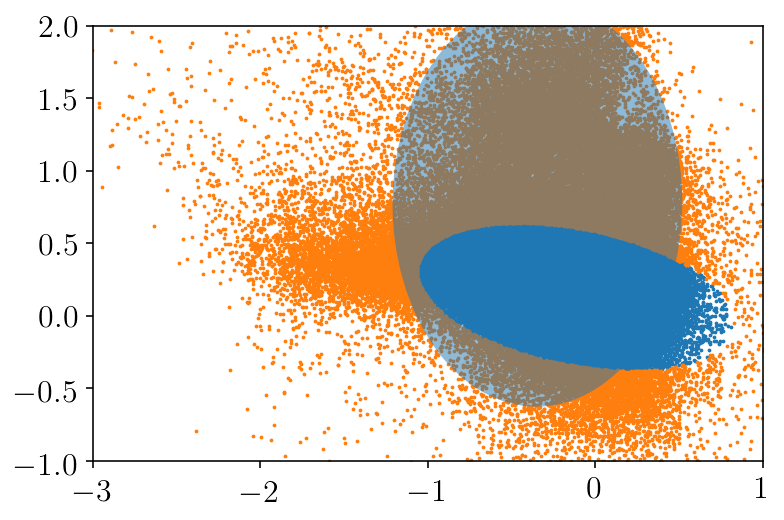

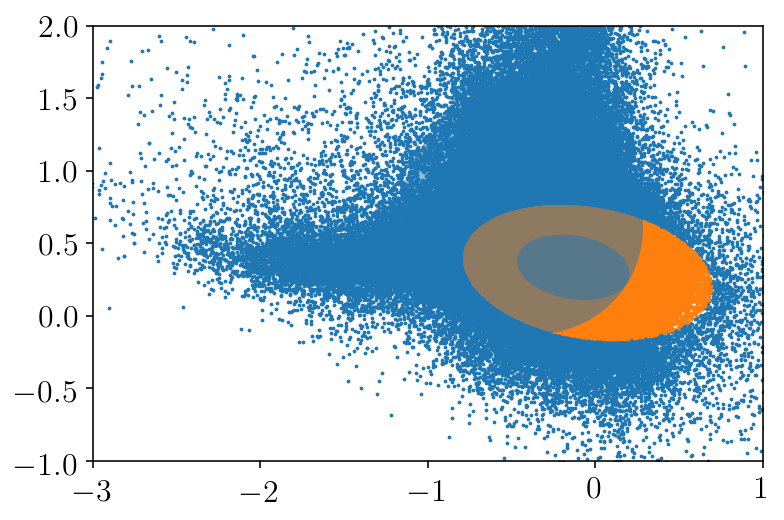

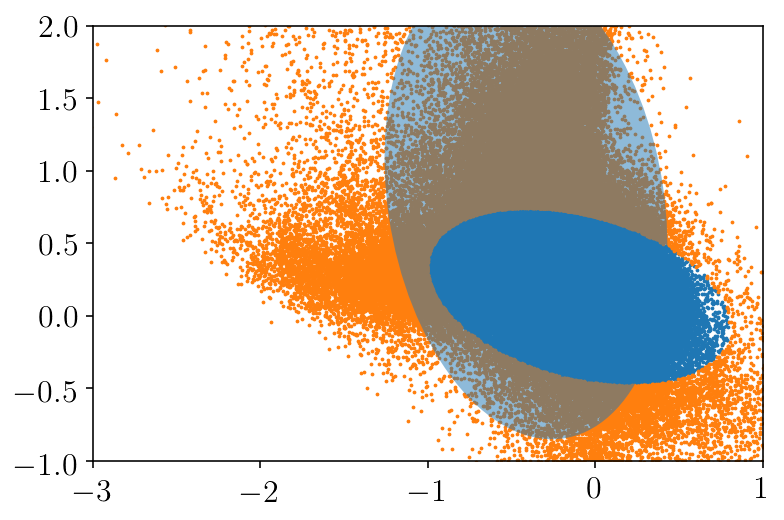

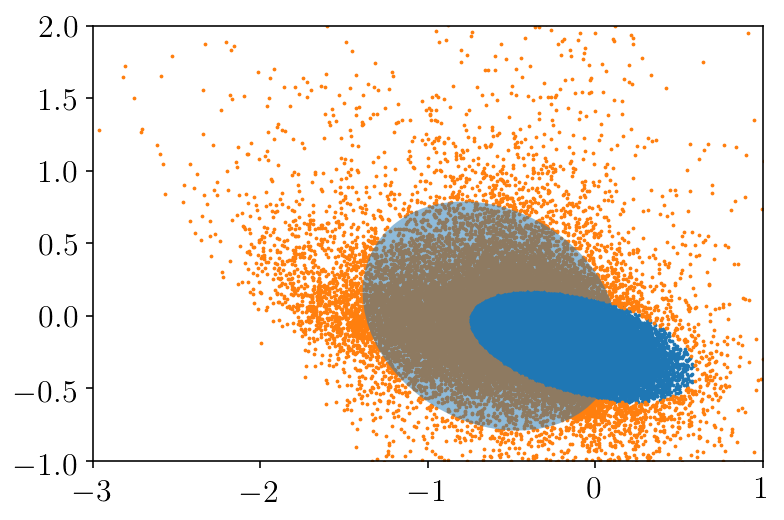

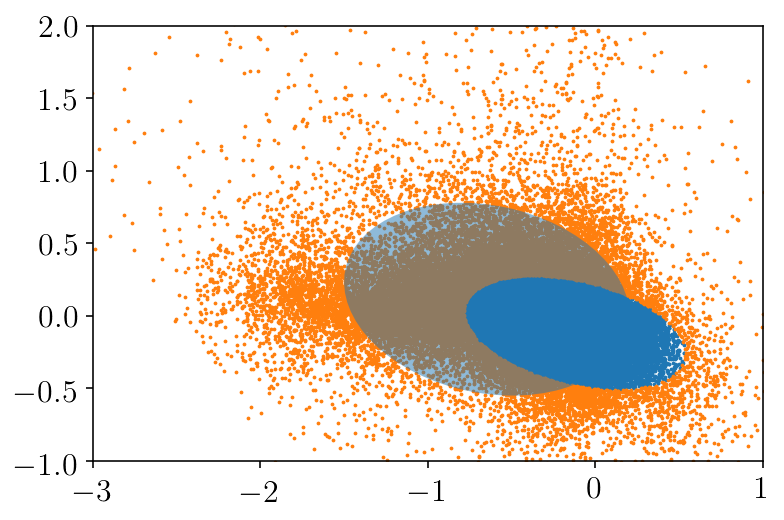

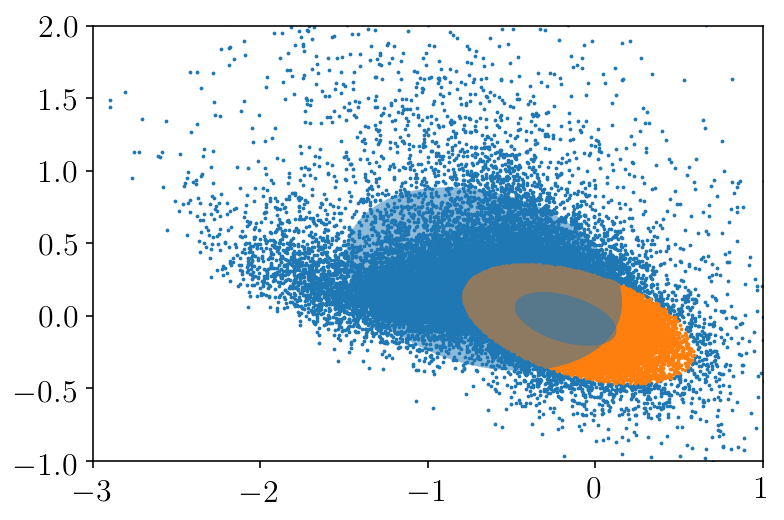

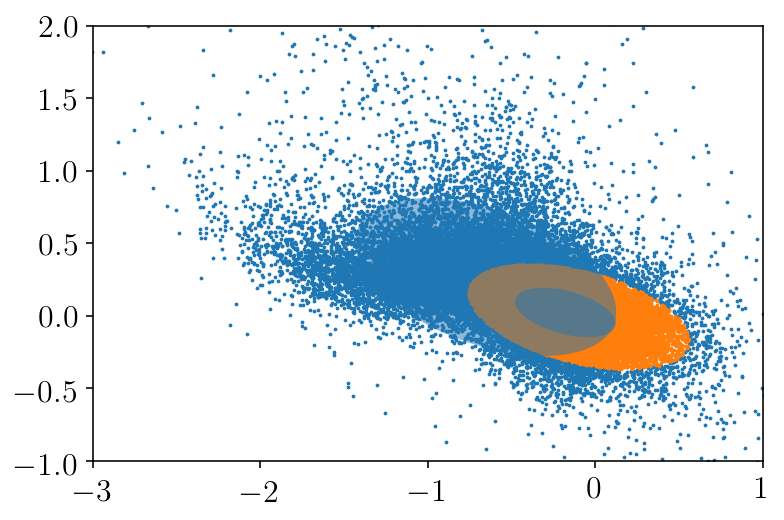

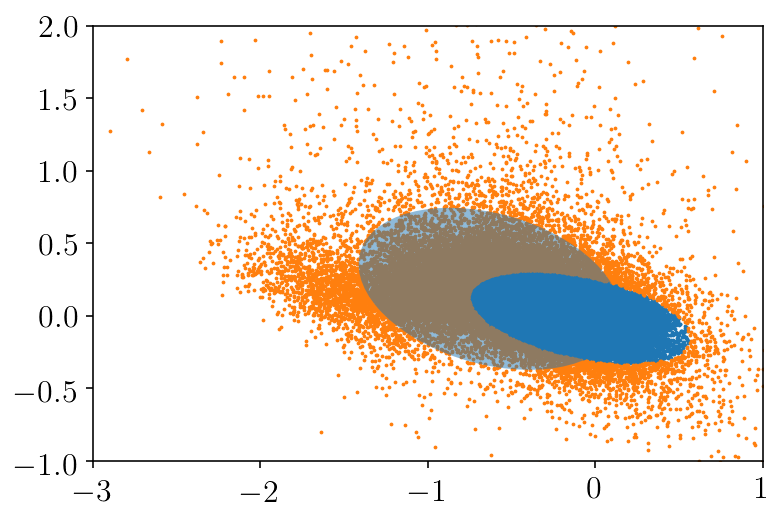

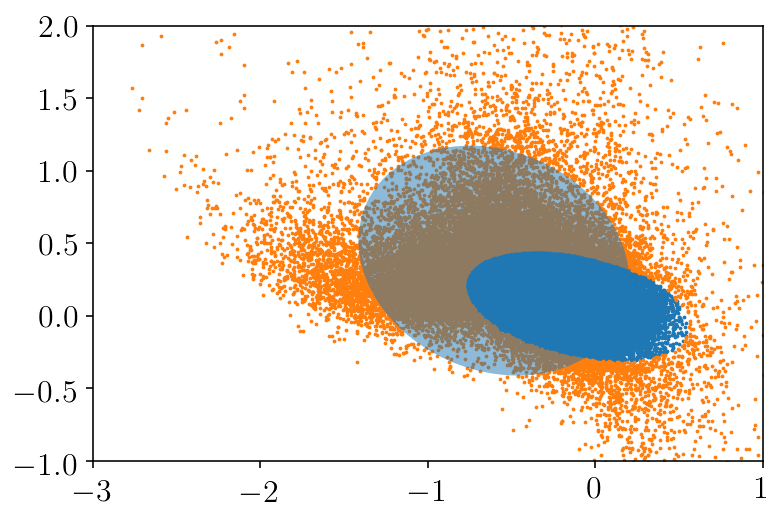

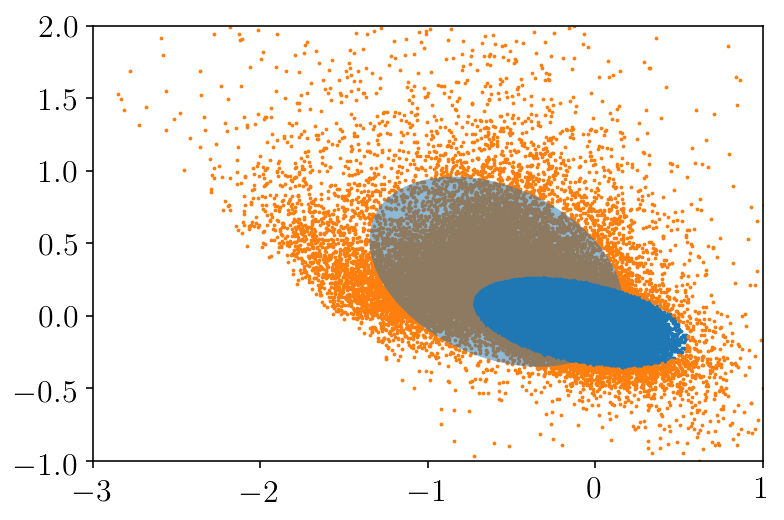

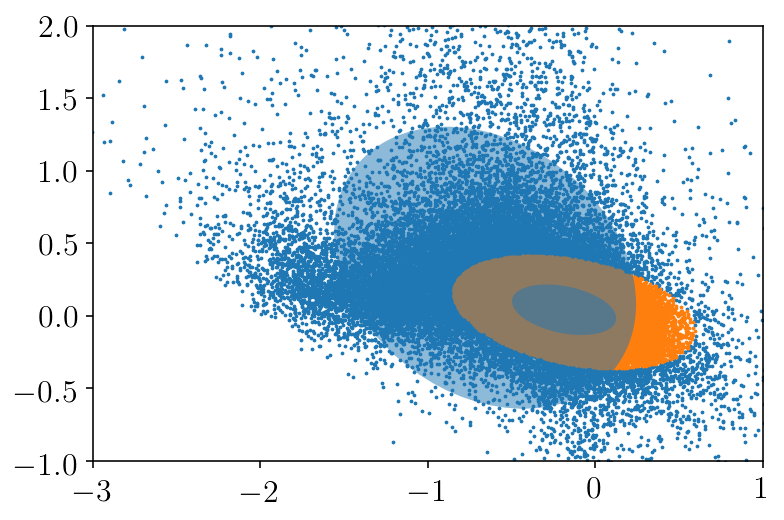

In [44]:
zeropoint = {}
zeropoint['MgI'] = 7.53
zeropoint['SiI'] = 7.51

offset = collections.OrderedDict()

for each_element in converter.keys():
    for each_index, each_line in enumerate(converter[each_element]): 
        print(each_line)
        useful = np.isfinite(final_output_abundances['fe_h']) & np.isfinite(final_output_abundances['A_'+each_line])

        X = np.array([
            final_output_abundances['fe_h'][useful],
            final_output_abundances['A_'+each_line][useful] - zeropoint[each_element] - final_output_abundances['fe_h'][useful]
        ]).T

        clf = get_GMM(X)

        Y_ = clf.predict(X)

        f, (ax1) = plt.subplots(1)

        gmm_mean = clf.means_
        #print(gmm_mean[:,0])
        high_mean = np.where(gmm_mean[:,0] == np.max(gmm_mean[:,0]))[0][0]
        offset['A_'+each_line] = gmm_mean[high_mean,1]

        for i, (mean, cov) in enumerate(zip(clf.means_, clf.covariances_)):
            v, w = linalg.eigh(cov)
            if not np.any(Y_ == i):
                continue
            plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8)

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180. * angle / np.pi  # convert to degrees
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180. + angle)
            ell.set_clip_box(ax1.bbox)
            ell.set_alpha(.5)
            ax1.add_artist(ell)
            ax1.set_xlim(-3,1)
            ax1.set_ylim(-1,2)

print(offset)

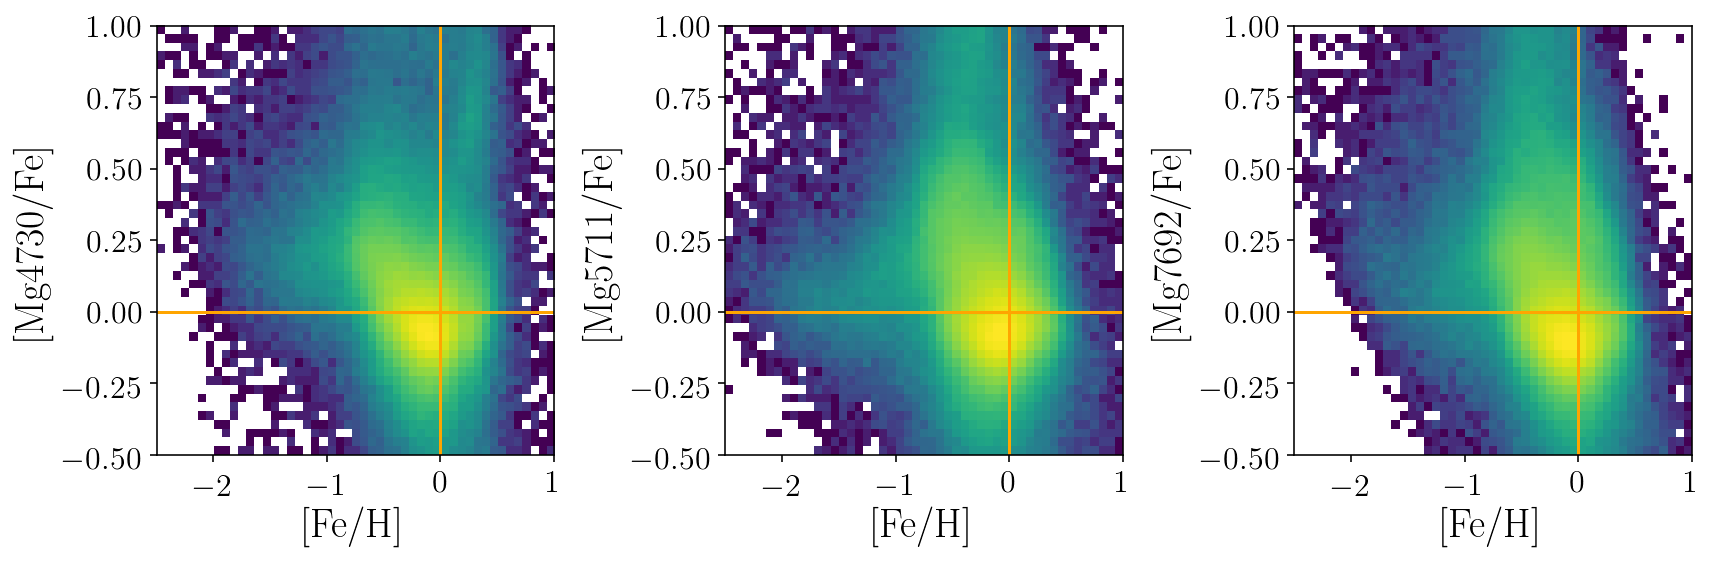

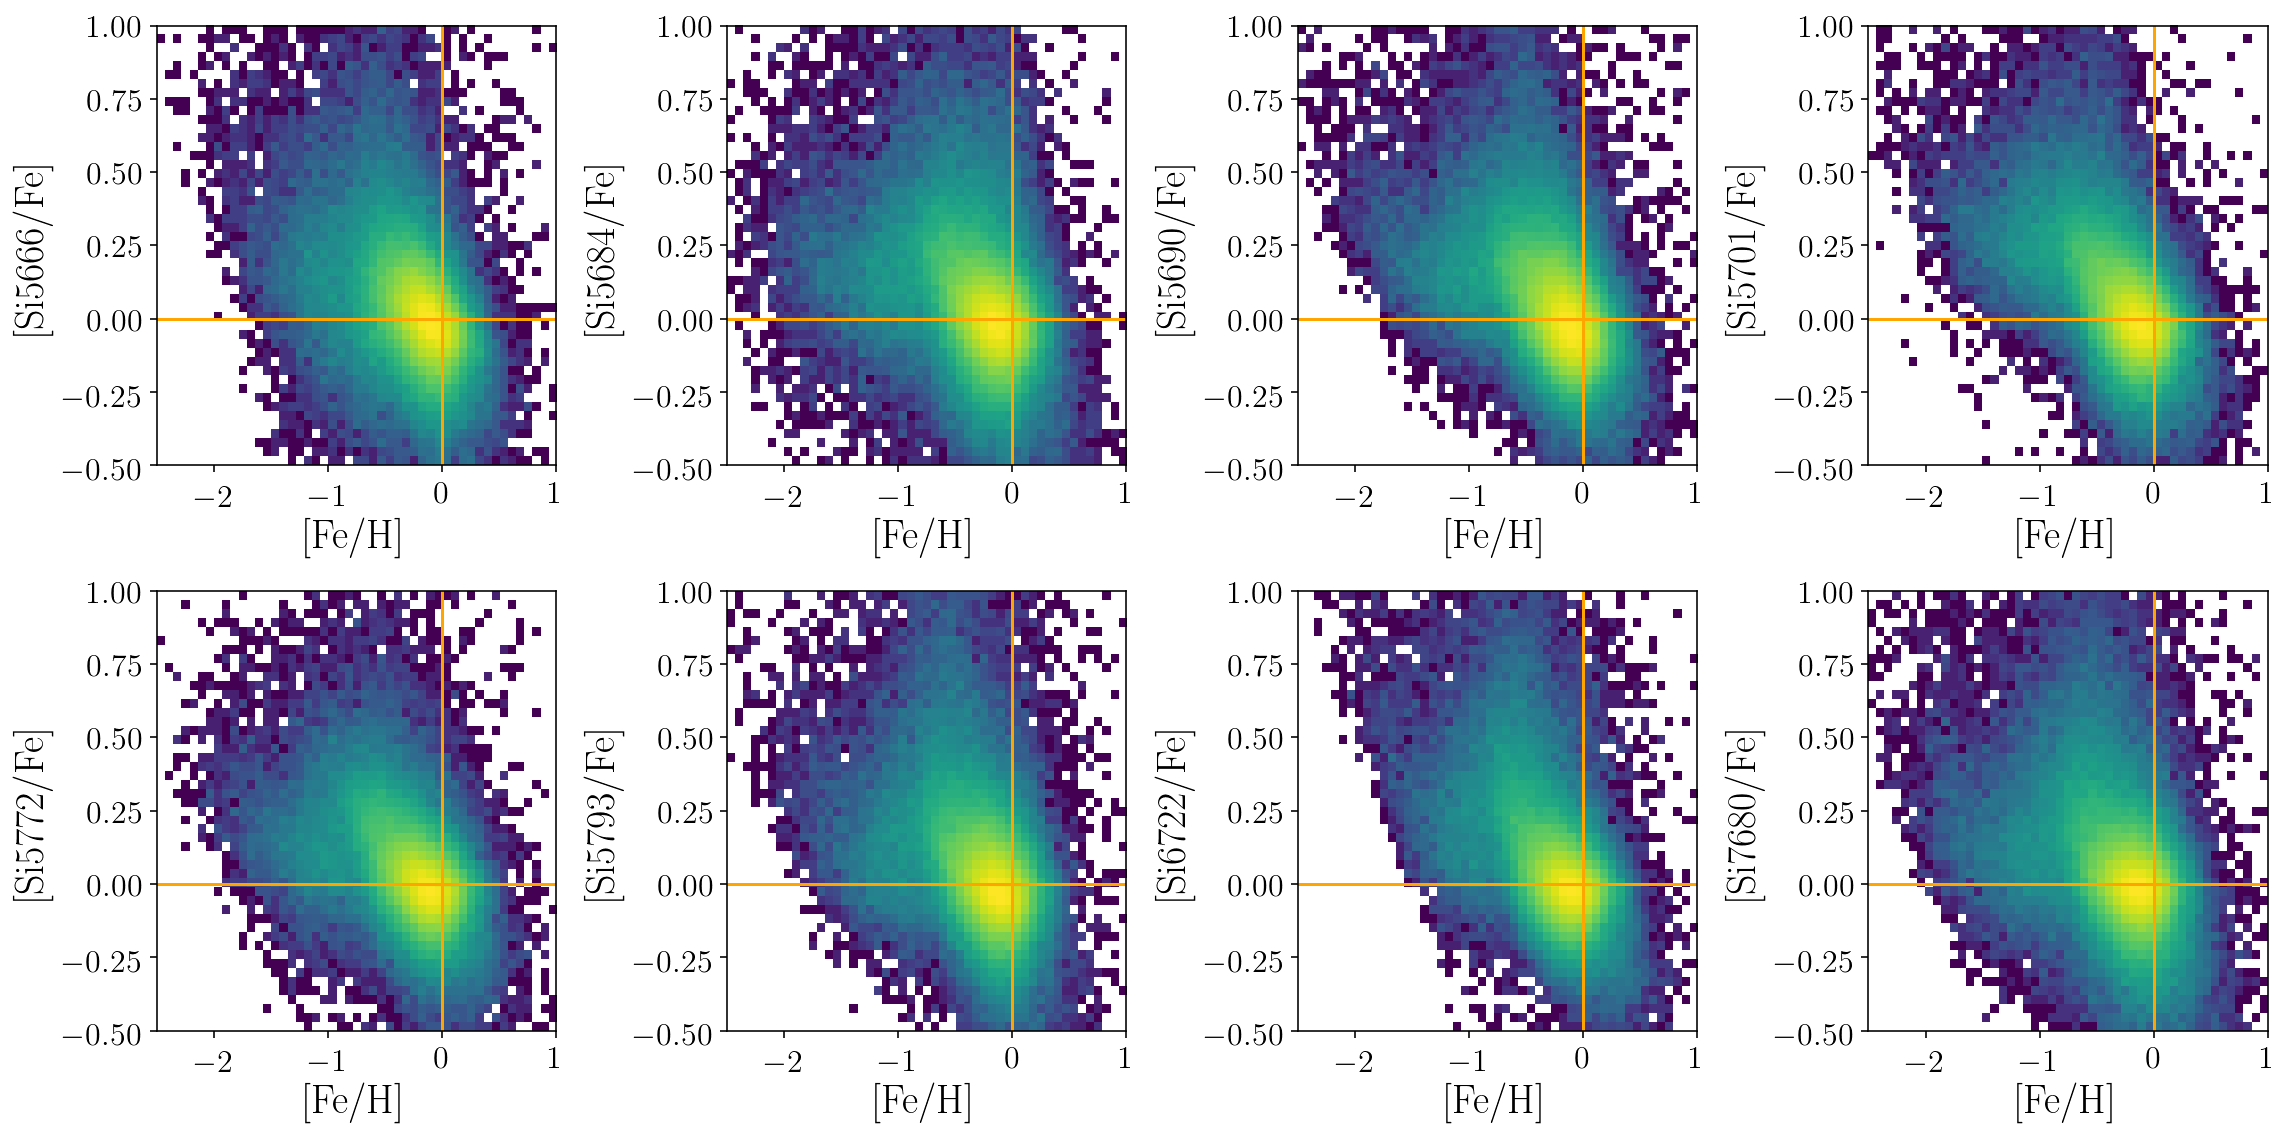

In [57]:
for each_element in converter.keys():

    if each_element == 'MgI':
        figsize = (12,4)
        subplots = [1,3]
    if each_element == 'SiI':
        figsize = (16,8)
        subplots = [2,4]
    
    f = plt.figure(figsize=figsize)

    for each_index, each_line in enumerate(converter[each_element]):
        ax = plt.subplot(subplots[0],subplots[1],each_index+1)

        ax.hist2d(
            final_output_abundances['fe_h'],
            final_output_abundances['A_'+each_line] - offset['A_'+each_line] - zeropoint[each_element] - final_output_abundances['fe_h'],
            bins = (
                np.linspace(-2.5,1.0,50),
                np.linspace(-0.5,1.0,50)
                ),
            cmin=1,
            norm=LogNorm()
        )

        ax.set_xlabel('[Fe/H]')
        ax.set_ylabel('['+each_line+'/Fe]')
        ax.axvline(0,c='orange')
        ax.axhline(0,c='orange')

    plt.tight_layout()

In [ ]:
f = plt.figure(figsize=(15,7.5))

for each_index, each_line in enumerate(converter['MgI']):
    ax = plt.subplot(2,4,each_index+1)
    
    ax.hist2d(
        final_output_abundances['fe_h'],
        final_output_abundances['A_'+converter['MgI'][each_index]] - offset['A_'+converter['MgI'][each_index]] - 7.51 - final_output_abundances['fe_h'],
        bins = (
            np.linspace(-2.5,1.0,50),
            np.linspace(-0.5,1.0,50)
            ),
        cmin=1,
        norm=LogNorm()
    )

    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('['+converter['SiI'][each_index]+'/Fe]')
    ax.axvline(0,c='orange')
    ax.axhline(0,c='orange')

plt.tight_layout()

In [220]:
    converter = collections.OrderedDict()
#     converter['LiI']  = ['Li']
#     converter['CI']   = ['C6588']
#     converter['OI']   = ['O7772','O7774','O7775']
#     converter['NaI']  = ['Na5683','Na5688'] # leaving out Na4752
#     converter['MgI']  = ['Mg4730','Mg5711','Mg7692'] # leaving out Mg7722, Mg7759, Mg7811
#     converter['AlI']  = ['Al6696','Al6699','Al7835','Al7836']
    converter['SiI']  = ['Si5666','Si5684','Si5690','Si5701','Si5772','Si5793','Si6722','Si7680']
#     converter['KI']   = ['K5802','K7699']
#     converter['CaI']  = ['Ca5857','Ca5868','Ca6494','Ca6500'] # leaving out Ca6509
#     converter['ScI']  = ['Sc4744','Sc4753','Sc5672','Sc5687','Sc5717','Sc5724']
#     converter['ScII'] = ['Sc5658','Sc5667','Sc5684','Sc6605']
#     converter['TiI']  = ['Ti4758','Ti4759','Ti4778','Ti4782','Ti4798','Ti4802','Ti4820','Ti5689','Ti5716','Ti5720','Ti5739','Ti5866','Ti6599','Ti6717','Ti7853']
#     converter['TiII'] = ['Ti4720','Ti4765','Ti4799','Ti4849','Ti4866','Ti4874']
#     converter['VI']   = ['V4747','V4784','V4797','V4832']
#     converter['CrI']  = ['Cr4775','Cr4789','Cr4801','Cr5702','Cr5720','Cr5788','Cr5845','Cr6630']
#     converter['CrII'] = ['Cr4848']
#     converter['MnI']  = ['Mn4739','Mn4762','Mn4766','Mn4783']
#     converter['FeI']  = ['Fe4789','Fe4793','Fe4794','Fe4803','Fe4808','Fe4876','Fe4890','Fe4891','Fe5651','Fe5652','Fe5661','Fe5663','Fe5679','Fe5680','Fe5696','Fe5702','Fe5705','Fe5731','Fe5732','Fe5742','Fe5775','Fe5778','Fe5807','Fe5809','Fe5812','Fe5815','Fe5850','Fe5853','Fe5855','Fe5859','Fe6482','Fe6495','Fe6499','Fe6518','Fe6546','Fe6593','Fe6594','Fe6598','Fe6609','Fe6628','Fe6648','Fe6678','Fe6699','Fe6704','Fe6714','Fe6725','Fe6733','Fe7710','Fe7723','Fe7748']
#     converter['FeII'] = ['Fe4720','Fe4731','Fe4833','Fe6516','Fe7712']
#     converter['CoI']  = ['Co5647','Co6632','Co7713','Co7838']
#     converter['NiI']  = ['Ni5847','Ni6586']
#     converter['CuI']  = ['Cu5700','Cu5782']
#     converter['ZnI']  = ['Zn4722','Zn4811']
#     converter['RbI']  = ['Rb7800']
#     converter['SrI']  = ['Sr6550']
#     converter['YII']  = ['Y4855','Y4884','Y5663']
#     converter['ZrI']  = ['Zr4739','Zr4772','Zr4806','Zr4828']
#     converter['MoI']  = ['Mo5751','Mo5858']
#     converter['RuI']  = ['Ru4869']
#     converter['BaII'] = ['Ba5854','Ba6497']
#     converter['LaII'] = ['La4716','La4749','La4804','La5806']
#     converter['CeII'] = ['Ce4774']
#     converter['NdII'] = ['Nd4811','Nd5741','Nd5770','Nd5812','Nd5842']
#     converter['SmII'] = ['Sm4837','Sm4854']
#     converter['EuII'] = ['Eu5819','Eu6645']
#     converter['alpha_fe'] = ['Mg4730','Mg5711','Mg7692','Si5666','Si5684','Si5690','Si5701','Si5772','Si5793','Si6722','Si7680','Ca5857','Ca5868','Ca6494','Ca6500','Ti4758','Ti4759','Ti4778','Ti4782','Ti4798','Ti4802','Ti4820','Ti5689','Ti5716','Ti5720','Ti5739','Ti5866','Ti6599','Ti6717','Ti7853']
    

In [221]:
def combine_line_by_line(
    final_output_data, 
    final_output_abundances, 
    abundance_zeropoints,
    flag_limit = 0, 
    abundance_uncertainty_limit = 0.005,
    clip_outlier_sigma = 2,
    debug = False,
    converter = converter
    ):
    
    """
    We combine all line measurements 
    for a given element and species 
    as outlined in the converter dictionary, 
    e.g. OI is a combination of O7772, O7774, O7775
    
    Only measurements up to the 
    flag_limit are considered
    
    Abundance uncertainties are set be 
    at least above the abundance_uncertainty_limit
    
    Only use those measurements that are as close as 2 sigma
    to the error-weighted mean and recompute it

    
    """
    
    print('Only using A(X) with flags <= '+str(flag_limit))
    print('Setting uncertainty floor for A(X) to >= '+str(abundance_uncertainty_limit))
    
    """
    ii=where(mode eq 'Mg' or mode eq 'Si' or mode eq 'Ti')
    for i=0,n_elements(object)-1 do begin
       j=where(finite(res[i].abund[ii]) and res[i].aflag[ii] eq 0,jc)
       if jc ne 0 then begin
          res[i].alpha_fe   = total(res[i].abund[ii[j]]/res[i].e_abund[ii[j]]^2)/total(1./res[i].e_abund[ii[j]]^2)
          res[i].e_alpha_fe = sqrt(1./total(1./res[i].e_abund[ii[j]]^2))
          ;print,res[i].alpha_fe,res[i].e_alpha_fe,res[i].e_teff                                                                                                                                                
       endif
    endfor
    """
    
    def combine_line_measurements_for_element(each_element, final_output_data, final_output_abundances):

        """
        We convert the measurements to [X/H] before we combine them

        """

        useful_line_bitmask = []
        useful_line_measurements = []
        useful_line_measurements_raw = []
        useful_line_uncertainties = []

        for each_index, each_line in enumerate(converter[each_element]):
            
            # if line measurement flag is <= flag_limit
            if (
                (final_output_data['flag_'+each_line] <= flag_limit) &
                np.isfinite(final_output_abundances['A_'+each_line])
            ):

                useful_line_bitmask.append(2**each_index)
                useful_line_measurements.append(final_output_abundances['A_'+each_line] - abundance_zeropoints['A_'+each_line][0] - final_output_abundances['fe_h'])
                # useful_line_measurements_raw.append(final_output_abundances['A_'+each_line] - offset['A_'+each_line] - 7.51 - final_output_abundances['fe_h'])
                useful_line_uncertainties.append(final_output_data['cov_e_'+each_line])
                
        useful_line_bitmask=np.array(useful_line_bitmask)
        useful_line_measurements=np.array(useful_line_measurements)
        # useful_line_measurements_raw=np.array(useful_line_measurements_raw)
        useful_line_uncertainties=np.array(useful_line_uncertainties)
        
        if debug==True:
            print(useful_line_bitmask, useful_line_measurements, useful_line_uncertainties)

        if len(useful_line_measurements) == 1:
            return(useful_line_measurements[0], useful_line_uncertainties[0],1)
        elif len(useful_line_measurements) != 0:
            
            all_lines = (
                np.sum(useful_line_measurements/useful_line_uncertainties**2)/np.sum(1./useful_line_uncertainties**2),
                np.sqrt(1./np.sum(1./useful_line_uncertainties**2) + np.var(useful_line_measurements)),
                np.sum(useful_line_bitmask)
                )
                
            sigma_outliers = np.abs(all_lines[0] - useful_line_measurements) > clip_outlier_sigma*all_lines[1]

            if debug==True:
                print(useful_line_measurements,all_lines,sigma_outliers)
                print(useful_line_measurements[~sigma_outliers])
            
            if len(useful_line_measurements[~sigma_outliers]) < 2:
                return(all_lines)
            else:
                return(
                    np.sum(useful_line_measurements[~sigma_outliers]/useful_line_uncertainties[~sigma_outliers]**2)/np.sum(1./useful_line_uncertainties[~sigma_outliers]**2),
                    np.sqrt(1./np.sum(1./useful_line_uncertainties[~sigma_outliers]**2) + np.var(useful_line_measurements)),
                    np.sum(useful_line_bitmask[~sigma_outliers])
                )
        else:
            return(np.nan,np.nan,np.nan)

    for each_element in converter.keys():
        (final_output_data[each_element+'_fe'], final_output_data['cov_e_'+each_element], final_output_data['nr_'+each_element]) = np.array([combine_line_measurements_for_element(each_element, final_output_data[data_index], final_output_abundances[data_index]) for data_index in range(len(final_output_abundances['sobject_id']))]).T

    return(final_output_data['fe_h'], final_output_data[each_element+'_fe'], final_output_data['cov_e_'+each_element])

Only using A(X) with flags <= 0
Setting uncertainty floor for A(X) to >= 0.005


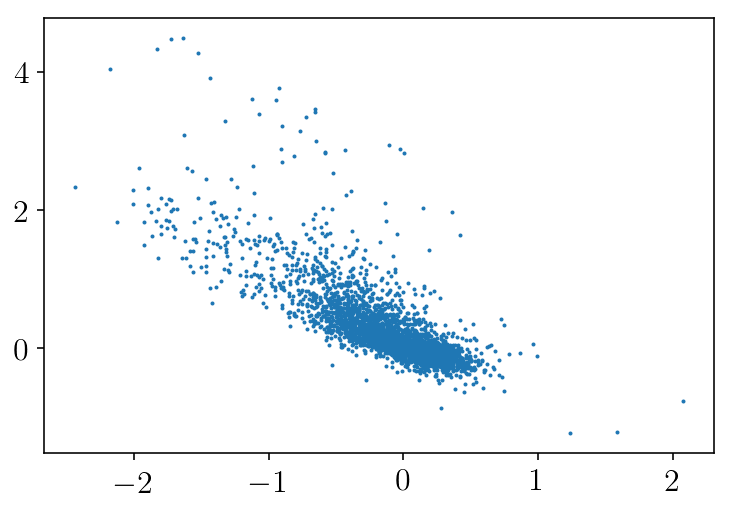

In [222]:
abundance_zeropoints= Table.read('../abundance_zeropoints/galahdr3_abundance_zeropoints.fits',1)

converter = collections.OrderedDict()
converter['SiI_fe']  = ['Si5666','Si5684','Si5690','Si5701','Si5772','Si5793','Si6722','Si7680']

#(final_output_data,final_output_abundances) =  combine_line_by_line(final_output_data, final_output_abundances, abundance_zeropoints)
(fe_h,si_fe,e_si_fe) =  combine_line_by_line(
    final_output_data[-20000:], 
    final_output_abundances[-20000:], 
    abundance_zeropoints,
    converter=converter
)

plt.scatter(fe_h,si_fe,s=1)

Only using A(X) with flags <= 0
Setting uncertainty floor for A(X) to >= 0.005
Only using A(X) with flags <= 0
Setting uncertainty floor for A(X) to >= 0.005
Only using A(X) with flags <= 0
Setting uncertainty floor for A(X) to >= 0.005
Only using A(X) with flags <= 0
Setting uncertainty floor for A(X) to >= 0.005


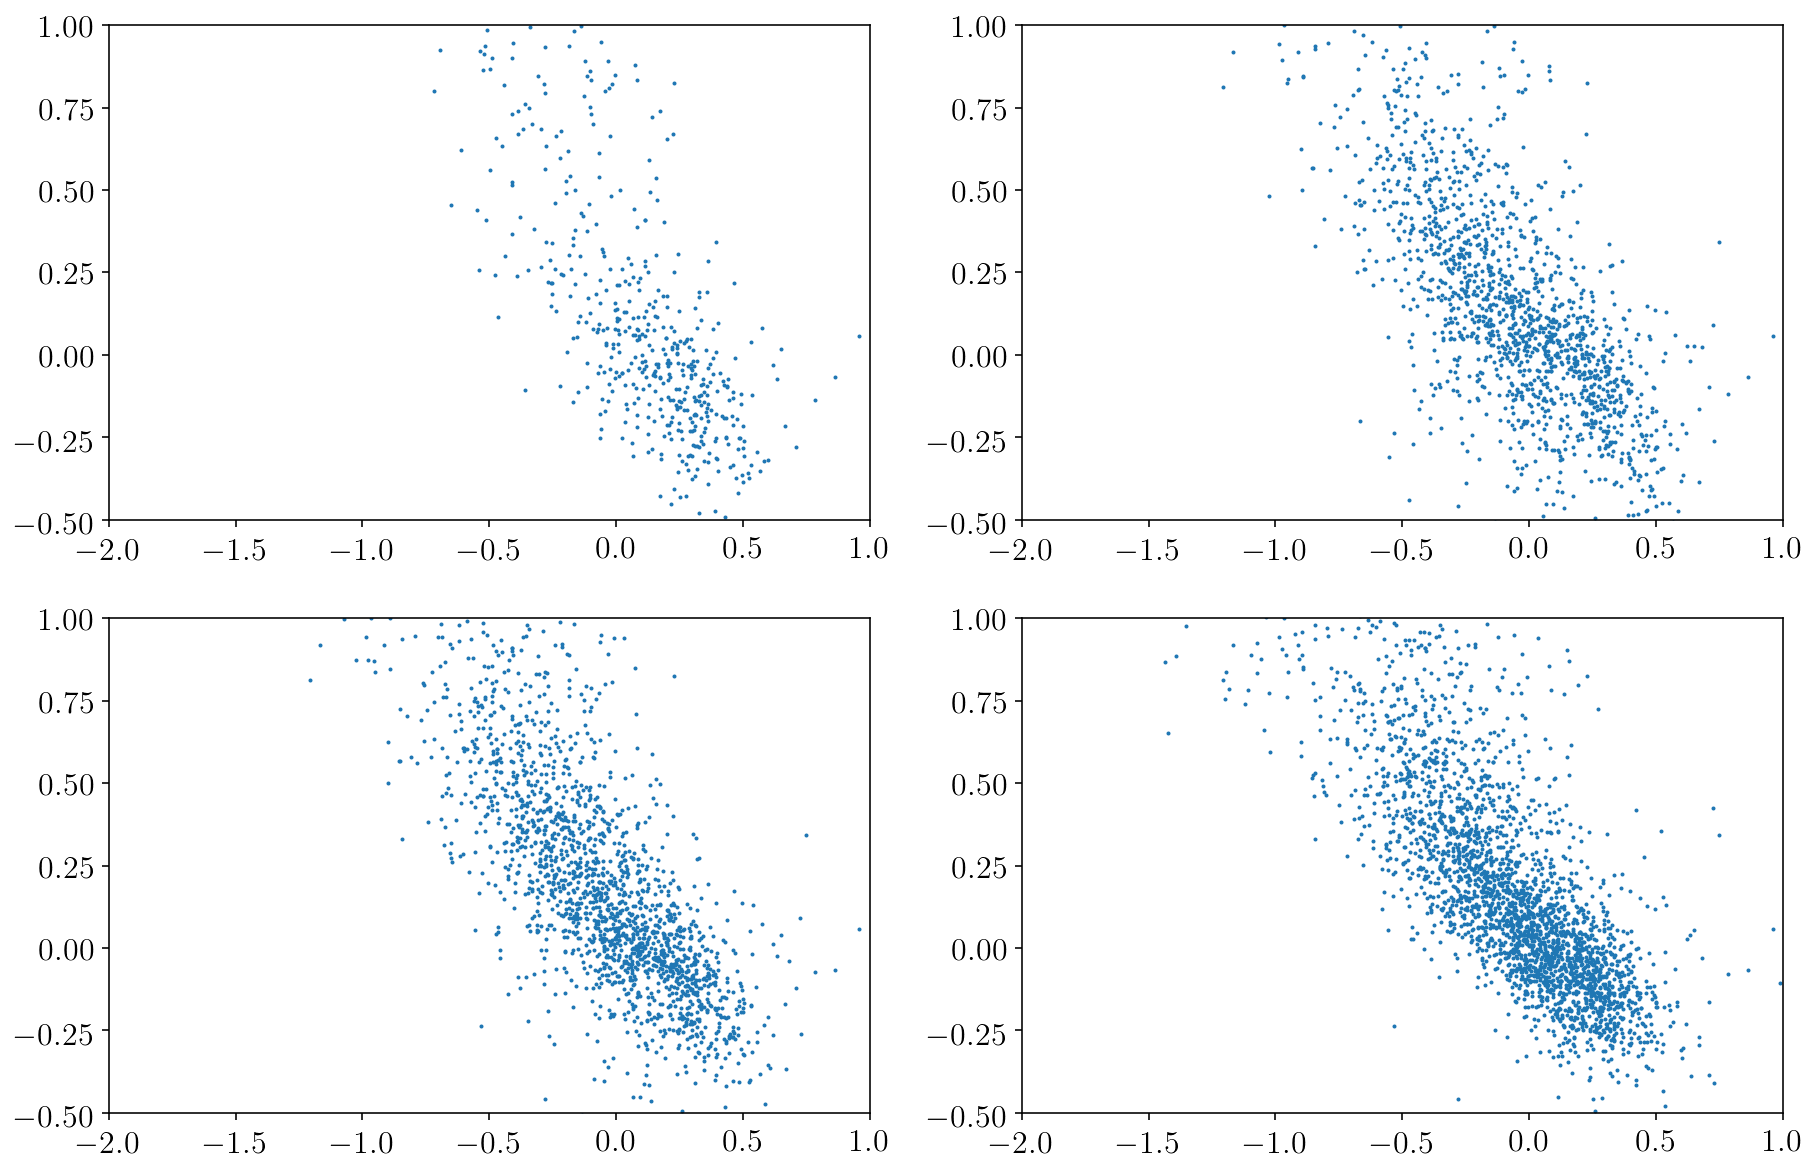

In [229]:
f = plt.figure(figsize=(15,10))
for each_index, each_combi in enumerate(
    [
        ['Si5666'],
        ['Si5666','Si5684'],
        ['Si5666','Si5684','Si5690','Si5701'],
        ['Si5666','Si5684','Si5690','Si5701','Si5772','Si5793','Si6722','Si7680']
    ]):
    
    converter = collections.OrderedDict()
    converter['SiI_fe']  = each_combi

    #(final_output_data,final_output_abundances) =  combine_line_by_line(final_output_data, final_output_abundances, abundance_zeropoints)
    (fe_h,si_fe,e_si_fe) =  combine_line_by_line(
        final_output_data[-20000:], 
        final_output_abundances[-20000:], 
        abundance_zeropoints,
        converter=converter
    )
    
    ax = plt.subplot(2,2,each_index+1)
    ax.set_xlim(-2.0,1.0)
    ax.set_ylim(-0.5,1.0)

    ax.scatter(fe_h,si_fe,s=1)